# Trailblazers Qualification Challenge.
## By Alvin Kimata.

# 1. Import libraries and datasets.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor

plt.style.use('seaborn-whitegrid')

In [3]:
train = pd.read_csv('inputs/Train.csv')
test = pd.read_csv('inputs/Test.csv')
ss = pd.read_csv('inputs/SampleSubmission.csv')
variable_data = pd.read_csv('inputs/variable_descriptions.csv')

train.head()

,ward,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,...,pw_03,pw_04,pw_05,pw_06,pw_07,pw_08,ADM4_PCODE,lat,lon,NL
0,41601001: Ward 1,1674.45058,5888.20750,16.773757,0.933841,0.000846,0.005490,0.000676,0.000000,0.001372,...,0.002848,0.007537,0.000000,0.012928,0,0,ZA4161001,-29.682270,24.734743,0.292039
1,41601002: Ward 2,1736.99230,6735.33812,21.496661,0.696940,0.001253,0.004402,0.000000,0.002301,0.001323,...,0.014566,0.057127,0.019092,0.004131,0,0,ZA4161002,-29.119311,24.757737,3.207775
2,41601003: Ward 3,2403.57591,7273.04995,10.931425,0.810545,0.004517,0.008891,0.003986,0.007735,0.000956,...,0.057560,0.010358,0.001421,0.040881,0,0,ZA4161003,-29.142276,25.094093,0.000000
3,41601004: Ward 4,1740.78737,5734.49046,23.119257,0.659914,0.000000,0.006129,0.000000,0.000813,0.037245,...,0.000000,0.000669,0.000000,0.005011,0,0,ZA4161004,-29.372052,24.942867,2.038778
4,41601005: Ward 5,1730.51451,6657.23835,13.652252,0.950575,0.000655,0.001473,0.000598,0.006999,0.000818,...,0.004859,0.001290,0.000673,0.017629,0,0,ZA4161005,-29.409381,25.290165,0.000000


In [4]:
#make a copy of the train and test splits.
copy_train = train.copy()
copy_test = test.copy()

df = pd.concat([copy_train, copy_test], axis = 0).reset_index(drop = True)

In [5]:
#Group columns according to their similarities in the variable_descriptions file.
dw_cols = [cols for cols in df.reset_index(drop = True) if cols.startswith('dw')]
psa_cols = [cols for cols in df.reset_index(drop = True) if cols.startswith('psa')]
stv_cols = [cols for cols in df.reset_index(drop = True) if cols.startswith('stv')]
car_cols = [cols for cols in df.reset_index(drop = True) if cols.startswith('car')]
lln_cols = [cols for cols in df.reset_index(drop = True) if cols.startswith('lln')]
lan_cols = [cols for cols in df.reset_index(drop = True) if cols.startswith('lan')]
pg_cols = [cols for cols in df.reset_index(drop = True) if cols.startswith('pg')]
pw_cols = [cols for cols in df.reset_index(drop = True) if cols.startswith('pw')]

# 2.EDA.

<AxesSubplot:>

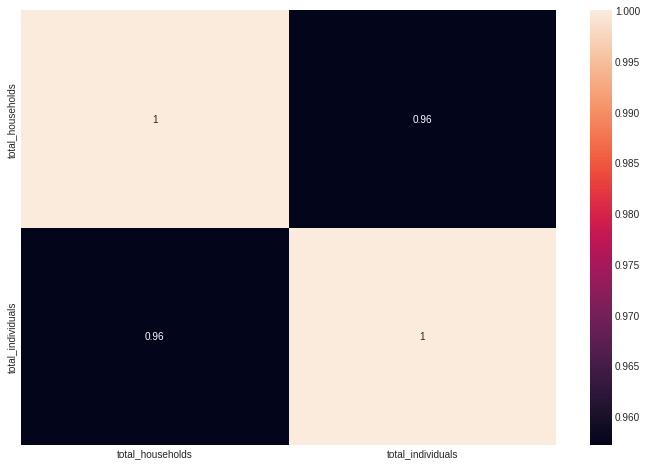

In [6]:
corr = df[['total_households', 'total_individuals']].corr()
plt.figure(figsize = (12, 8))
sns.heatmap(corr.abs(), annot = True)

- *total_individuals* and *total_households* features are highly correlational , hence we drop one feature between the two.

<AxesSubplot:>

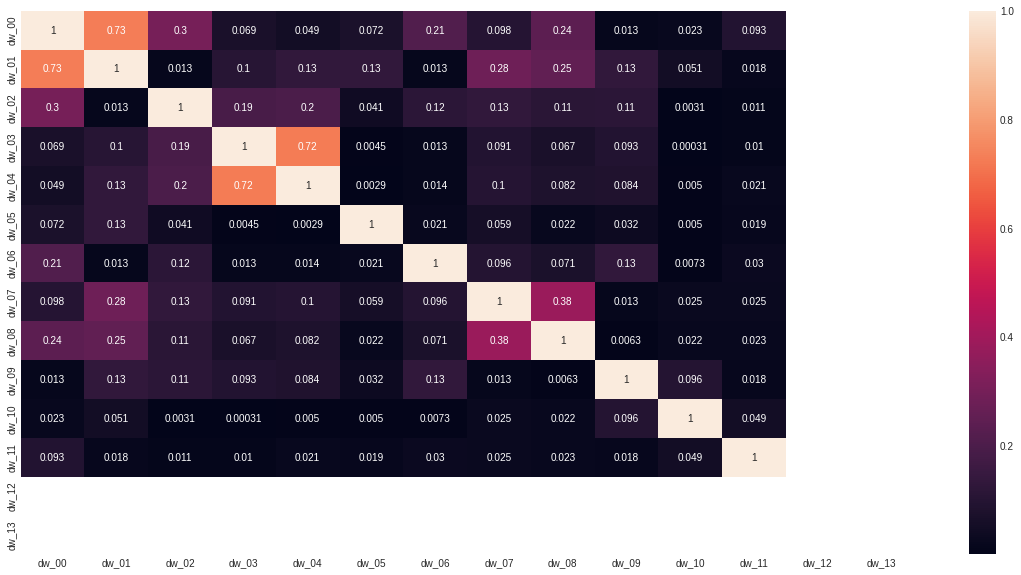

In [7]:
#Dwellings type columns.
corr = df[dw_cols].corr()
plt.figure(figsize = (20, 10))
sns.heatmap(corr.abs(), annot = True)

- *dw_12* and *dw_13* do not have any values, hence we drop them.
- *dw_01* and *dw_02* seem to be highly correlated, also dw_03 and dw_04. Hence, we need to drop one of them.
- The same case applies to *dw_03* and *dw_04*.

<AxesSubplot:title={'center':'Percentage listing present in schools'}>

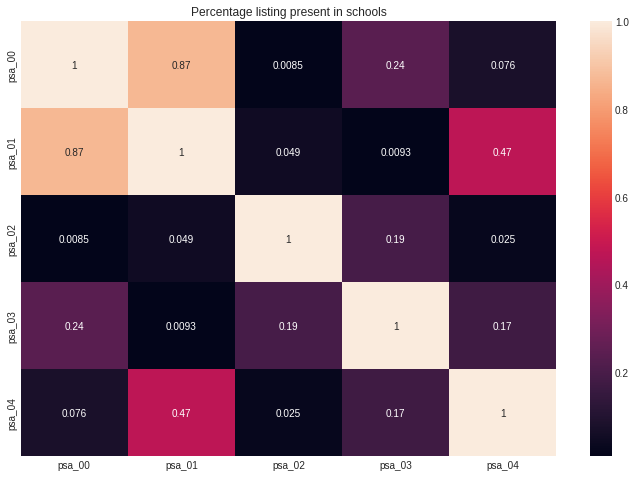

In [8]:
#School attendance columns.
corr = df[psa_cols].corr()
plt.figure(figsize = (12, 8))
plt.title('Percentage listing present in schools')
sns.heatmap(corr.abs(), annot = True)

- psa_00 and psa_01 are highly correlated, hence we drop one of them.

<AxesSubplot:title={'center':'Percentage of households with satellite TV'}>

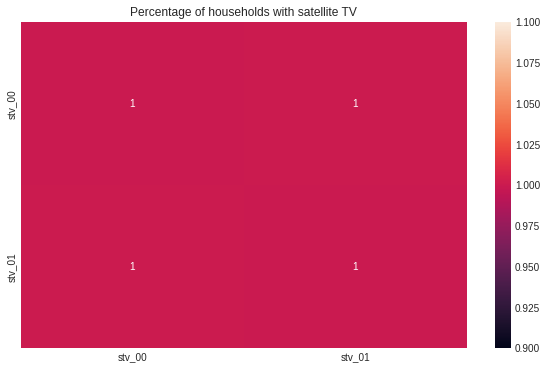

In [9]:
corr = df[stv_cols].corr()
plt.figure(figsize = (10, 6))
plt.title('Percentage of households with satellite TV')
sns.heatmap(corr.abs(), annot = True)

- *stv_00* and *stv_01* features are highly correlational!

<AxesSubplot:title={'center':'Heatmap showing percentage listing language.'}>

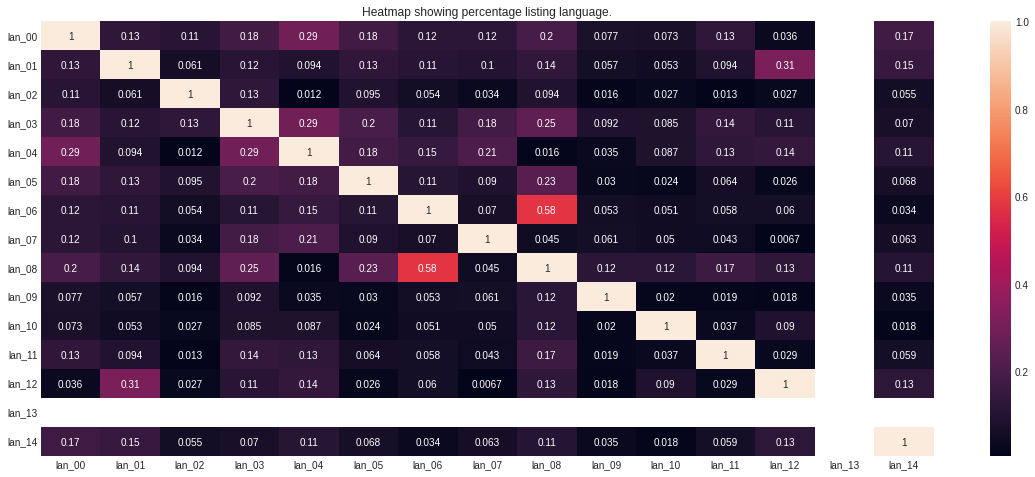

In [10]:
corr = df[lan_cols].corr()
plt.figure(figsize = (20, 8))
plt.title('Heatmap showing percentage listing language.')
sns.heatmap(corr.abs(), annot = True)

- We need to drop column *lan_13* as it has no values'

<AxesSubplot:title={'center':'Heatmap showing correlation in percentage in population groups'}>

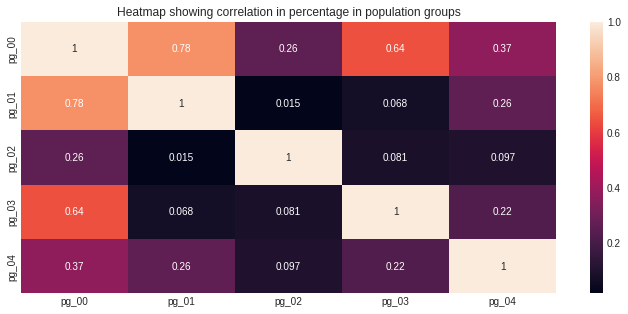

In [11]:
#PG columns. (Population group columns.)

corr = df[pg_cols].corr()
plt.figure(figsize = (12, 5))
plt.title('Heatmap showing correlation in percentage in population groups') 
sns.heatmap(corr.abs(), annot = True)

- From the below plot, we can see that *pg_00* and *pg_03* are highly correlational.

<AxesSubplot:title={'center':'Heatmap showing correlation in percentage of population with piped water access.'}>

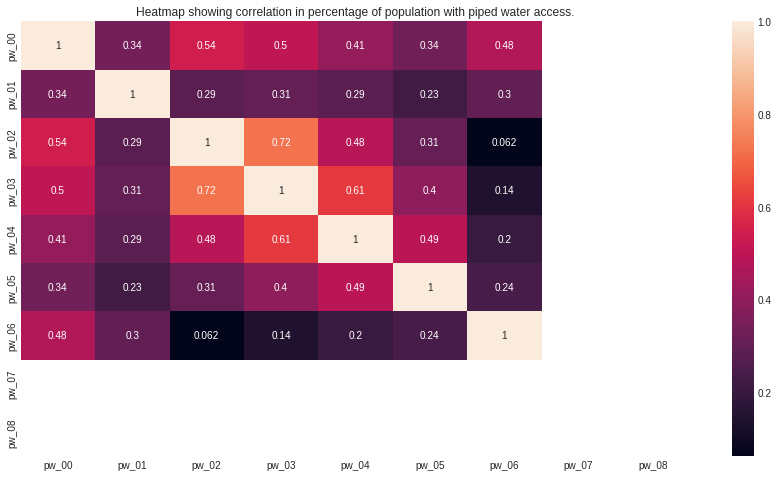

In [12]:
#PW (Piped water columns).
corr = train[pw_cols].corr()
plt.figure(figsize = (15, 8))
plt.title('Heatmap showing correlation in percentage of population with piped water access.')
sns.heatmap(corr.abs(), annot = True)

# 3. Data wrangling.

In [13]:
PATTERN = r'[\d\s]+:'
df['Ward_Category'] = df['ward'].str.replace(PATTERN, '', regex = True)

#Code category feature.
def create_code_category(data_frame):
    data_frame['Code_Category'] = data_frame['ADM4_PCODE'].str[:3]
    data_frame['Code_Category'] = data_frame['Code_Category'].map({
        'ZA5' : 'ZA5', 'ZA7' : 'ZA7', 'ZA9' : 'ZA9',
        'ZA6' : 'ZA6', 'ZA8' : 'ZA8', 'ZA4' : 'ZA4',
        'ZA3' : 'ZA3', 'ZA2' : 'ZA2', 'ZA1' : 'ZA1'})
    return data_frame

df = create_code_category(df)
df['Individuals_Households_ratio'] = df['total_individuals'] / df['total_households']

In [14]:
#Identify categorical features for encoding.
cat_cols = [cols for cols in df.columns if df[cols].dtypes == 'object']
encoder = OrdinalEncoder(handle_unknown = 'error')
df[cat_cols] = encoder.fit_transform(df[cat_cols])

In [15]:
kmeans = KMeans(n_clusters = 8) # Default number of clusters.
df['Ward_Cluster'] = kmeans.fit_predict(df.loc[:, ['lat', 'lon', 'ward']])
df['Ward_Cluster'] = df['Ward_Cluster'].astype('int')

df['SplitBy'] = df['ward'].astype(int) #KFold splits.
df = df.drop_duplicates('SplitBy').reset_index(drop = True)

In [16]:
#Split data into original train and test splits.
train_size = copy_train.shape[0]

train = df.iloc[:train_size, ]

test = df.iloc[train_size:, ]
test = test.drop('target', axis = 1).reset_index(drop = True)

In [17]:
train

,ward,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,...,pw_08,ADM4_PCODE,lat,lon,NL,Ward_Category,Code_Category,Individuals_Households_ratio,Ward_Cluster,SplitBy
0,1189.0,1674.45058,5888.20750,16.773757,0.933841,0.000846,0.005490,0.000676,0.000000,0.001372,...,0.0,1189.0,-29.682270,24.734743,0.292039,0.0,3.0,3.516501,1,1189
1,1190.0,1736.99230,6735.33812,21.496661,0.696940,0.001253,0.004402,0.000000,0.002301,0.001323,...,0.0,1190.0,-29.119311,24.757737,3.207775,42.0,3.0,3.877587,1,1190
2,1191.0,2403.57591,7273.04995,10.931425,0.810545,0.004517,0.008891,0.003986,0.007735,0.000956,...,0.0,1191.0,-29.142276,25.094093,0.000000,53.0,3.0,3.025929,1,1191
3,1192.0,1740.78737,5734.49046,23.119257,0.659914,0.000000,0.006129,0.000000,0.000813,0.037245,...,0.0,1192.0,-29.372052,24.942867,2.038778,64.0,3.0,3.294194,1,1192
4,1193.0,1730.51451,6657.23835,13.652252,0.950575,0.000655,0.001473,0.000598,0.006999,0.000818,...,0.0,1193.0,-29.409381,25.290165,0.000000,75.0,3.0,3.846971,1,1193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2817,1184.0,3261.68067,11551.56486,6.393480,0.874972,0.003146,0.017230,0.004735,0.048888,0.000654,...,0.0,1184.0,-27.675590,23.057920,9.118927,0.0,2.0,3.541599,1,1184
2818,1185.0,1463.06432,7908.90411,15.668000,0.636235,0.002262,0.010433,0.000000,0.003030,0.000000,...,0.0,1185.0,-27.591408,22.907161,1.697395,42.0,2.0,5.405712,1,1185
2819,1186.0,1395.18881,6242.37527,13.238795,0.855975,0.006601,0.061118,0.000812,0.003912,0.000812,...,0.0,1186.0,-27.952550,22.749698,2.792501,53.0,2.0,4.474215,1,1186
2820,1187.0,1679.66964,8014.73089,17.639523,0.792552,0.004423,0.016099,0.000000,0.000674,0.000000,...,0.0,1187.0,-27.913875,22.755314,2.793699,64.0,2.0,4.771611,1,1187


In [18]:
cols_to_drop = ['ward', 'ADM4_PCODE', 'psa_01', 'stv_01', 'car_01', 'lln_01','dw_12', 'dw_13', 'dw_01', 
                'dw_03', 'psa_01', 'stv_00', 'pg_00', 'lan_13', 'dw_12', 'pw_02', 'pw_07', 'pw_08', 'total_individuals', 'SplitBy']

X = train.drop('target', axis = 1)
X = X.drop(cols_to_drop, axis = 1)

y = train['target']
test = test.drop(cols_to_drop, axis = 1)

In [19]:
SEED = 42

rf_params = {
    'n_estimators': 200,
    'n_jobs': 6,
    'random_state': SEED
}

kf = GroupKFold(n_splits = 10)
kf.get_n_splits(X, y)

10

In [20]:
model_preds = []
y_preds = []
rmse_metrics = []
groups = train['SplitBy']
fold = 0

for train_index, test_index in kf.split(X, y, groups):
    print(50 * '-')
    print(f'Fold {fold} / {kf.get_n_splits(X, y)}')
    fold += 1
    
    X_train, X_test = X.iloc[train_index,: ], X.iloc[test_index,: ]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = RandomForestRegressor(**rf_params)
    estimator = model.fit(X_train, y_train)
    
    y_pred = estimator.predict(X_test)
    print(f'FOLD - {fold} MSE: {mean_squared_error(y_test, y_pred)}, RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
    y_preds.append(y_pred)
    rmse_metrics.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    y_pred_test = estimator.predict(test)
    model_preds.append(y_pred_test)
    

--------------------------------------------------
Fold 0 / 10
FOLD - 1 MSE: 14.101813173249559, RMSE: 3.755238098077079
--------------------------------------------------
Fold 1 / 10
FOLD - 2 MSE: 12.59654745848891, RMSE: 3.5491615148495157
--------------------------------------------------
Fold 2 / 10
FOLD - 3 MSE: 9.674258899812758, RMSE: 3.1103470706358087
--------------------------------------------------
Fold 3 / 10
FOLD - 4 MSE: 9.26442944901208, RMSE: 3.043752527557403
--------------------------------------------------
Fold 4 / 10
FOLD - 5 MSE: 11.384702178810086, RMSE: 3.374122430915939
--------------------------------------------------
Fold 5 / 10
FOLD - 6 MSE: 11.166668275072782, RMSE: 3.341656516620579
--------------------------------------------------
Fold 6 / 10
FOLD - 7 MSE: 13.232570708941548, RMSE: 3.637660059563228
--------------------------------------------------
Fold 7 / 10
FOLD - 8 MSE: 10.21441194526787, RMSE: 3.1959993656551107
----------------------------------

In [21]:
np.mean(rmse_metrics)

3.4225222143451672

In [22]:
sub_file = ss.copy()
sub_file['target'] = np.mean(model_preds, axis = 0)
sub_file.to_csv('submissions/91st_submission.csv', index = False)

In [23]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y, discrete_features = 'auto')
    mi_scores = pd.Series(mi_scores, name = 'MI scores', index = X.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores

In [24]:
mi_scores = make_mi_scores(X, y)
mi_scores

psa_00                          0.538925
pw_00                           0.520084
car_00                          0.508647
lln_00                          0.442385
pg_03                           0.420192
lan_00                          0.405614
pg_01                           0.398985
lan_01                          0.361612
lan_03                          0.333477
lat                             0.302020
psa_04                          0.292584
lon                             0.286512
pg_04                           0.271524
lan_04                          0.270409
lan_07                          0.258842
lan_06                          0.252476
NL                              0.251337
Code_Category                   0.247994
pg_02                           0.232134
dw_04                           0.228944
Individuals_Households_ratio    0.227064
lan_12                          0.222669
pw_06                           0.211232
dw_06                           0.207767
lan_05          

In [25]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending = True)
    width = range(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title('Mutual Information scores')

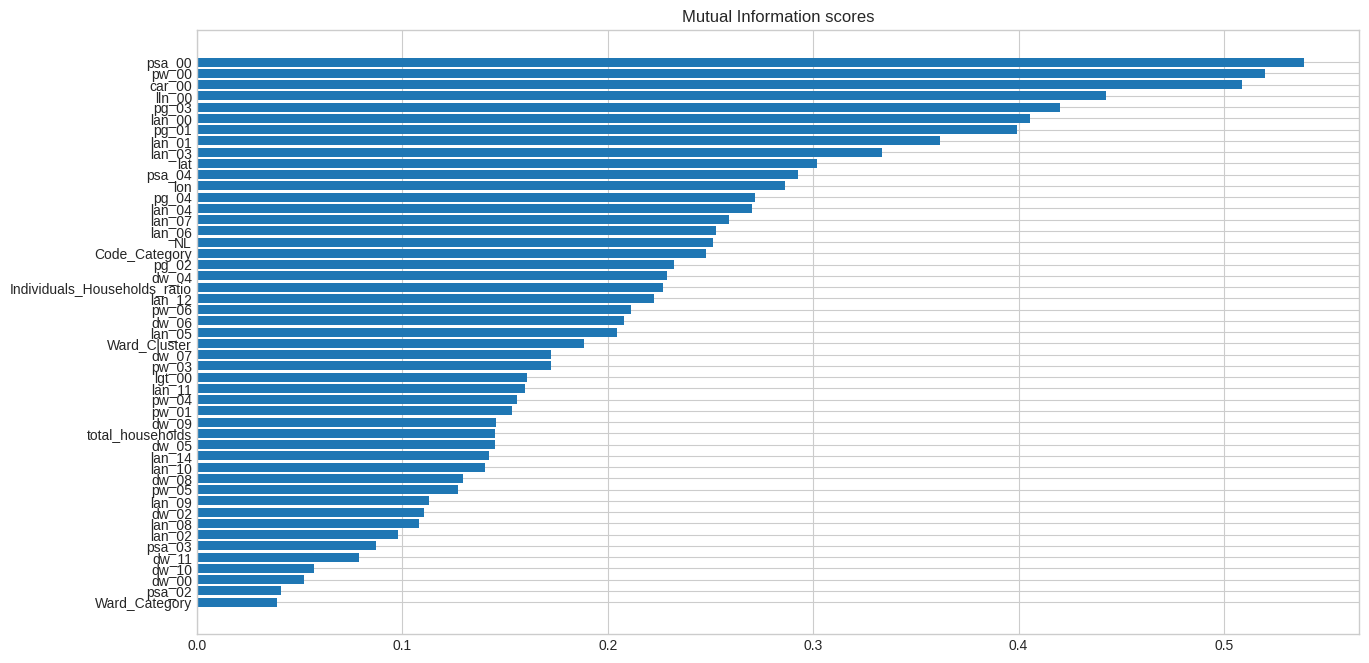

In [26]:
plt.figure(dpi = 100, figsize = (15, 8))
plot_mi_scores(mi_scores)